# Regressão via processos gaussianos (Gaussian Process Regression - GPR) para estimativas da dinâmica epidêmica da COVID19

 Referências: <br>
 
 [1] https://scikit-learn.org/stable/modules/gaussian_process.html <br>
 [2] https://towardsdatascience.com/quick-start-to-gaussian-process-regression-36d838810319 <br>
 [3] RW2006(1,2,3,4,5,6) Carl Eduard Rasmussen and Christopher K.I. Williams, “Gaussian Processes for Machine Learning”, MIT Press 2006, http://www.gaussianprocess.org/gpml/chapters/RW.pdf<br>




In [1]:
import scipy.io
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from scipy import signal

Text(0.5, 1.0, 'COVID')

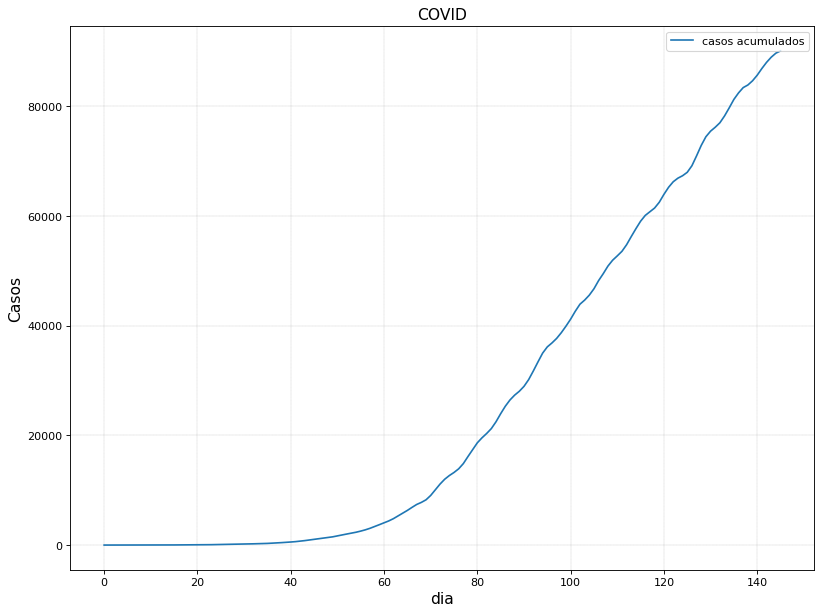

In [2]:
# Importa os dados

data = scipy.io.loadmat('..\\Dados\\cumCasesPB.mat')['cumCasesPB']
#data = scipy.io.loadmat('cumCasesPB_14-10_filtered.mat')['cumCasesPB']
#data = scipy.io.loadmat('cumCasesCG15Set.mat')['cumCasesCG']
#data = scipy.io.loadmat('randomDB1km.mat')['cumCasesCG']
#data = scipy.io.loadmat('randomDB5km.mat')['cumCasesCG']
# data = scipy.io.loadmat('randomDB5kmCidades.mat')['cumCasesCG']
#data = scipy.io.loadmat('randomDB5kmNacoes.mat')['cumCasesCG']


trainL = max(data.shape[0], data.shape[1]) - 1 # número de dias  a partir do dia 1 utilizado como conjunto de 
                                               # treinamento. Por convenção usa-se todos os dias.
                                               # Espera-se dados na forma dados(1, Qtde_de_dias), mas pode vir ao contrário.
                                               # Foi usada a função max, para capturar a maior dimensão (Quantidade de dias)  
Ndias  = 3    # intervalo de média móvel
futDays = 14  # horizonte de previsão

# calcula média móvel dos dados
data  = np.reshape(data, data.size)
movAvFilter = np.ones(Ndias)/Ndias
movAvFilter = np.reshape(movAvFilter, movAvFilter.size)
data = signal.lfilter(movAvFilter, 1, data)

# escalona valores por milhares
CRdata = data/1000     
DRdata = np.diff(data.transpose())
DRdata = DRdata.transpose()/1000
plt.figure(1, figsize=(12, 9), dpi=80, facecolor='w', edgecolor='k')
plt.plot(data)
plt.legend(['casos acumulados'])
plt.grid(color='k', linestyle='--', linewidth=0.1)
plt.ylabel('Casos', fontsize = 14)
plt.xlabel('dia', fontsize = 14)
plt.title('COVID', fontsize = 14)

In [3]:
# Modelagem GPR para o número de casos acumulados

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, RBF, ExpSineSquared, DotProduct, Matern
from itertools import permutations

# Linha do tempo (entrada do modelo) e dados (saída do modelo)
t = np.linspace(1,len(DRdata)+futDays,len(DRdata)+futDays)
t = t.reshape(len(t),1)
t = np.atleast_2d(t)

CRdata  = np.ravel(CRdata)

# Define intervalo de treinamento
t_tr  = t[0:trainL]
CR_tr = CRdata[0:trainL]


# Define kernel a ser utilizado
#kernel = ConstantKernel()* Matern(1.0) + DotProduct()
# Define um conjunto de kernels
kernels = [ConstantKernel(), #0
           Matern(1.0),         #1 
           DotProduct(sigma_0=1e-05), #2
           ExpSineSquared(length_scale=1.86, periodicity=15.8), #3
           RBF(length_scale=1), #4
           ConstantKernel()* Matern(1.0) + DotProduct() #5
          ]

MSE_anterior = 1e15
qtdKernels = 3 # quantidade de kernels
elementos = range(qtdKernels) # lista com os indices dos kernels
combs = list(permutations(elementos, 2)) # lista com permutação dos indices
lista_MSE_Soma = [] # lista com os erros médios quadraticos para a soma
lista_MSE_Mult = [] # lista com os erros médios quadraticos para a multiplicação

for comb in combs:
  # Instancia classe GPR
  model_soma  = GaussianProcessRegressor(kernel = kernels[comb[0]] + kernels[comb[1]], n_restarts_optimizer=20, alpha = 0.1, normalize_y=False)
  model_mult  = GaussianProcessRegressor(kernel = kernels[comb[0]] * kernels[comb[1]], n_restarts_optimizer=20, alpha = 0.1, normalize_y=False)

  
  # Treinamento do modelo para a soma de kernels
  model_soma.fit(t_tr, CR_tr)
  print("\nLearned kernel: %s" % model_soma.kernel_)
  params_soma = model_soma.kernel_.get_params()

  # Treinamento do modelo para a mutplicação de kernels
  model_mult.fit(t_tr, CR_tr)
  print("\nLearned kernel: %s" % model_mult.kernel_)
  params_mult = model_mult.kernel_.get_params()

  # Previsões do modelo soma de kernels
  CRpred_soma_, sigma_soma_ = model_soma.predict(t_tr, return_std=True) # previsão no intervalo de treinamento
  CRpred_soma, sigma_soma   = model_soma.predict(t, return_std=True)    # previsão para todo o intervalo de dados
   
  #print(CRpred[CRpred.shape[0]-1])

  # Calcula o erro médio quadratico para a soma
  MSE_Soma = np.mean(((CRpred_soma_ - CR_tr)*1000)**2)
  print('MSE Soma = ',MSE_Soma)

  # Previsões do modelo multiplicação de kernels
  CRpred_mult_, sigma_mult_ = model_mult.predict(t_tr, return_std=True) # previsão no intervalo de treinamento
  CRpred_mult, sigma_mult   = model_mult.predict(t, return_std=True)    # previsão para todo o intervalo de dados
   
  #print(CRpred[CRpred.shape[0]-1])
  # Calcula o erro médio quadratico para a multiplicação
    
  MSE_Mult = np.mean(((CRpred_mult_ - CR_tr)*1000)**2)
  print('MSE Mult = ',MSE_Mult)  

  # Adiciona os erros a cada lista respectivamente
  lista_MSE_Mult.append(MSE_Soma) 
  lista_MSE_Mult.append(MSE_Mult) 
  
  # Testa soma  
  if (MSE_Soma < MSE_anterior):
    MSE_anterior = MSE_Soma
    Melhor_Kernel = model_soma.kernel_
    CRpred = CRpred_soma
    CRpred_ = CRpred_soma_
    
  # Testa multiplicao
  if (MSE_Mult < MSE_anterior):
    MSE_anterior = MSE_Mult
    Melhor_Kernel = model_mult.kernel_
    CRpred = CRpred_mult
    CRpred_ = CRpred_mult_
  print('MSE Atualizado = ', MSE_anterior)
  
# Calcula R2 do modelo:
R2_tr  = model_soma.score(t_tr, CR_tr)
R2     = model_soma.score(t[0:len(CRdata)], CRdata)

# Previsões do modelo
#CRpred_, sigma_ = model_soma.predict(t_tr, return_std=True) # previsão no intervalo de treinamento
#CRpred, sigma   = model_soma.predict(t, return_std=True)    # previsão para todo o intervalo de dados
#CRpred_, sigma_ = Melhor_Kernel.predict(t_tr, return_std=True) # previsão no intervalo de treinamento
#CRpred, sigma   = Melhor_Kernel.predict(t, return_std=True)    # previsão para todo o intervalo de dados

print('Melhor Kernel = ', Melhor_Kernel)
   
print(CRpred[CRpred.shape[0]-1])

MSE = np.mean(((CRpred_-CR_tr)*1000)**2)

  #if (MSE_old < MSE)
print("\nMSE: %f" % MSE)
print("\nSTD: %f" % np.sqrt(MSE))
print("\nR2 treinamento: %f" % R2_tr)
print("\nR2 todo intervalo de dados: %f" % R2)


Learned kernel: 32.9**2 + Matern(length_scale=32.7, nu=1.5)

Learned kernel: 124**2 * Matern(length_scale=411, nu=1.5)
MSE Soma =  172245.606236178
MSE Mult =  55078.0968788846
MSE Atualizado =  55078.0968788846

Learned kernel: 11.6**2 + DotProduct(sigma_0=18.6)

Learned kernel: 316**2 * DotProduct(sigma_0=1.82e+03)
MSE Soma =  117086979.00652543
MSE Mult =  116970680.80717193
MSE Atualizado =  55078.0968788846

Learned kernel: Matern(length_scale=32.7, nu=1.5) + 32.9**2

Learned kernel: Matern(length_scale=411, nu=1.5) * 124**2
MSE Soma =  172245.5927809346
MSE Mult =  55077.80691731434
MSE Atualizado =  55077.80691731434

Learned kernel: Matern(length_scale=22.1, nu=1.5) + DotProduct(sigma_0=15.5)

Learned kernel: Matern(length_scale=308, nu=1.5) * DotProduct(sigma_0=1e-05)
MSE Soma =  81232.534705943
MSE Mult =  47345.32326019846
MSE Atualizado =  47345.32326019846

Learned kernel: DotProduct(sigma_0=1e+05) + 316**2

Learned kernel: DotProduct(sigma_0=2.68e+03) * 316**2
MSE Soma =

In [4]:
# Plota resultados
plt.figure(1, figsize=(12, 9), dpi=80, facecolor='w', edgecolor='k')
mpl.style.use('default')

plt.plot(t[0:len(DRdata)+1], CRdata*1000, 'ko', markersize=6, mfc='none', linewidth=1, label=r'Casos acumulados')
plt.plot(t_tr, CR_tr*1000, 'k.', markersize=9, label='Dados de treinamento')
plt.plot(t, CRpred*1000, 'b-', label='Previsão via modelo GPR')
plt.fill(np.concatenate([t, t[::-1]]),
         np.concatenate([CRpred*1000 - 1.9600 * 1000*sigma,
                        (CRpred*1000 + 1.9600 * 1000*sigma)[::-1]]),
         alpha=.25, fc='b', ec='None', label='intervalo de confiança de 95%')
plt.legend(loc='upper left', fontsize = 14)
plt.ylim(0, CRpred[CRpred.shape[0]-1]*1000)
plt.xlim(1, np.size(t))
plt.grid(color='k', linestyle='--', linewidth=0.1)
plt.ylabel('Total de casos', fontsize = 14)
plt.xlabel('dia', fontsize = 14)
plt.title('COVID média móvel: %d dias' %Ndias, fontsize = 14)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)


NameError: name 'sigma' is not defined

In [ ]:
print(Melhor_Kernel)